In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [90]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
maxdate = pd.read_sql("SELECT MAX(date) FROM Measurement", engine)['MAX(date)'][0]
objdate = (dt.datetime.strptime(maxdate,'%Y-%m-%d')-dt.timedelta(days=365)).date()
objdate

datetime.date(2016, 8, 23)

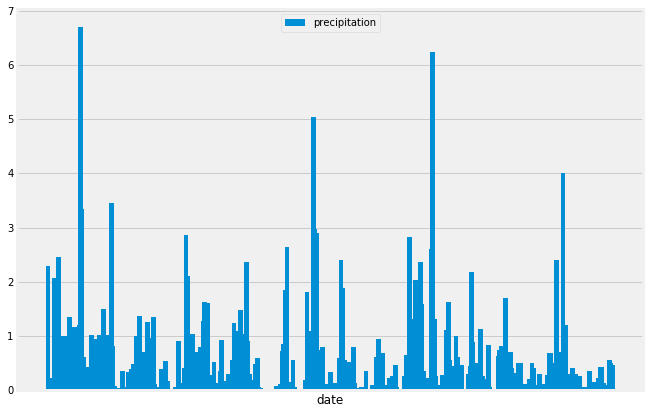

In [468]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = pd.read_sql("SELECT date,prcp AS precipitation FROM Measurement WHERE prcp NOT NULL AND date>'2016-08-23'",
                   engine,index_col="date")
# Sort the dataframe by date
prcp = prcp.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data
fig,ax = plt.subplots(figsize=(10,7))
ax.bar(prcp.index,prcp["precipitation"],width=3)
ax.set_xlabel("date")
ax.set_xticks([],[])
ax.legend(("precipitation",),loc=9)
plt.show()

In [469]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [470]:
# Design a query to show how many stations are available in this dataset?
station_no = pd.read_sql("SELECT count(station) FROM Station", engine)["count(station)"][0]
station_no

9

In [226]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_df = pd.read_sql("SELECT station,tobs FROM Measurement WHERE tobs NOT NULL",engine)
station_count = station_df.groupby("station").count()
station_count_sort = station_count.sort_values("tobs",ascending=False)
station_count_sort

,tobs
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [248]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_summary = pd.read_sql("SELECT min(tobs), max(tobs), sum(tobs)/count(tobs) FROM Measurement WHERE station='USC00519281'",engine).loc[0].to_list()
temp_summary

[54.0, 85.0, 71.66378066378067]

In [249]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hottest_station = pd.read_sql("SELECT station,max(tobs) FROM Measurement",engine)["station"][0]
hottest_station

'USC00519397'

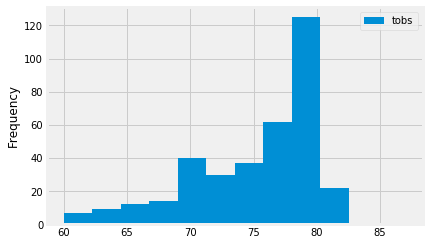

In [379]:
annual_temp_df = pd.read_sql("SELECT date,tobs FROM Measurement WHERE station='USC00519397' AND date>'2016-08-23'",engine)
fig,ax = plt.subplots()
ax.hist(annual_temp_df["tobs"],bins=12)
ax.legend(("tobs",),loc="best")
ax.set_ylabel("Frequency")
plt.show()

In [241]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [337]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
objtemps = calc_temps('2017-05-23','2017-06-05')
objtemps

[(69.0, 76.45121951219512, 87.0)]

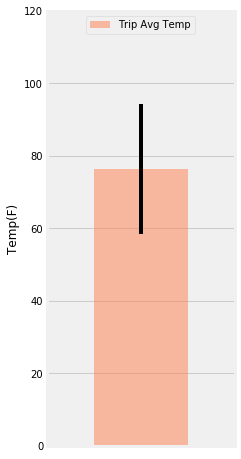

In [378]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
mintemp = objtemps[0][0]
maxtemp = objtemps[0][2]
avgtemp = objtemps[0][1]
yerror = maxtemp - mintemp
fig,ax = plt.subplots(figsize=(3,8))
ax.bar(0,objtemps[0][1],width=1,alpha=0.5,color='coral')
ax.errorbar(0,avgtemp,yerr=yerror,color='0')
plt.ylim(0,120)
plt.xlim(-1,1)
ax.set_ylabel("Temp(F)")
ax.legend(("Trip Avg Temp",),loc=9)
plt.xticks([],[])
plt.show()

In [406]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_df = pd.read_sql("SELECT Station.station,name,latitude,longitude,elevation,sum(prcp) \
                           FROM Station \
                           INNER JOIN Measurement ON (Measurement.station=Station.station)\
                           WHERE Measurement.prcp NOT NULL AND Measurement.date>'2017-05-22' AND Measurement.date<'2017-06-06'\
                           GROUP BY Station.station\
                           ORDER BY sum(prcp) DESC",engine).values.tolist()
rainfall_df

[['USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.829999999999999],
 ['USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.76],
 ['USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.08],
 ['USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.4200000000000002],
 ['USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.7200000000000001],
 ['USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.6900000000000001]]

## Optional Challenge Assignment

In [413]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [428]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = list()
# Set the start and end date of the trip
startdate = '2017-05-23'
enddate = '2017-06-05'
# Use the start and end date to create a range of dates
dates = pd.date_range(startdate,enddate)
# Stip off the year and save a list of %m-%d strings
dates_md = dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
for d in dates_md:
    normals.append(daily_normals(d)[0])

normals

[(68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0),
 (64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0),
 (68.0, 74.4, 81.0),
 (64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0)]

In [456]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temp = pd.DataFrame(normals,columns=['tmin','tavg','tmax'])
trip_temp['date'] = dates.strftime('%Y-%m-%d')
trip_temp = trip_temp[['date','tmin','tavg','tmax']]
trip_temp

,date,tmin,tavg,tmax
0,2017-05-23,68.0,74.948276,87.0
1,2017-05-24,67.0,73.948276,79.0
2,2017-05-25,68.0,74.275862,79.0
3,2017-05-26,65.0,74.036364,82.0
4,2017-05-27,65.0,74.490909,80.0
5,2017-05-28,67.0,74.277778,82.0
6,2017-05-29,64.0,74.196078,80.0
7,2017-05-30,69.0,74.333333,81.0
8,2017-05-31,68.0,74.400000,81.0
9,2017-06-01,64.0,74.614035,81.0


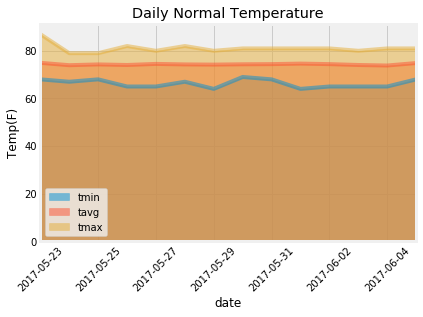

In [467]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_temp.plot.area("date",["tmin","tavg","tmax"],stacked=False)
plt.xticks(rotation=45)
ax.set_ylabel("Temp(F)")
ax.set_title("Daily Normal Temperature")
plt.show()